In [1]:
from PIL import Image, ImageFilter
import numpy as np
import os
from pylab import *

In [2]:
sys.setrecursionlimit(1000000000)

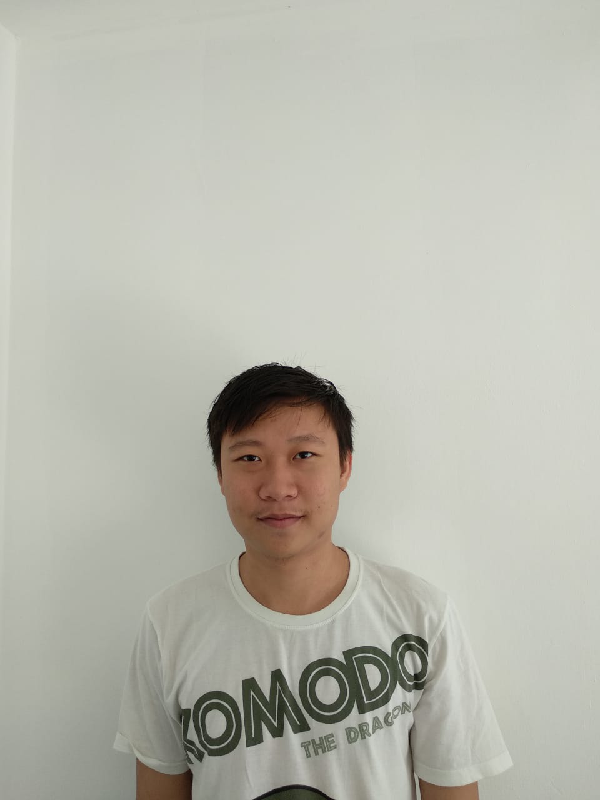

In [3]:
image = array(Image.open('agus2.jpeg').resize((600, 800)))
image_sobel = image.copy()
Image.fromarray(image)

In [4]:
image_new = image.copy()
for idx_row, row in enumerate(image):
    for idx_col, column in enumerate(row):
        image_new[idx_row][idx_col][0] = 0.299 * image[idx_row][idx_col][0] + 0.587 * image[idx_row][idx_col][1] + 0.114 * image[idx_row][idx_col][2]
        image_new[idx_row][idx_col][1] = 128 - 0.169 * image[idx_row][idx_col][0] - 0.331 * image[idx_row][idx_col][1] + 0.5 * image[idx_row][idx_col][2]
        image_new[idx_row][idx_col][2] = 128 + 0.5 * image[idx_row][idx_col][0] - 0.419 * image[idx_row][idx_col][1] - 0.081 * image[idx_row][idx_col][2]

In [5]:
# ( Y > 50)and (Y < 175) and
#  ( Cb > 90)and (Cb < 120) and ……….. (4)
#  ( Cr > 140)and (Cr < 165) and
#  ( Cr > 𝐶b)and (Cr − Cb > 15)
def isSkinColor(pixel):
    return pixel[0] > 80 and pixel[1] > 85 and pixel[1] < 135 and pixel[2] > 135 and pixel[2] < 180
#     return pixel[0] > 50 and pixel[0] < 175 and pixel[1] > 90 and pixel[1] < 120 and pixel[2] > 140 and pixel[2] < 165 and pixel[2] > pixel[1] and pixel[2] - pixel[1] > 15

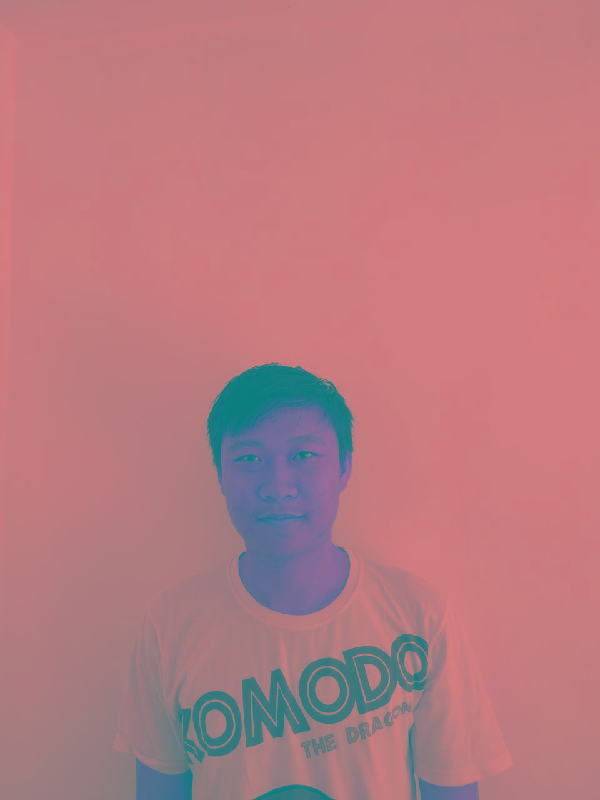

In [6]:
Image.fromarray(image_new)

In [7]:
image_face = image_new.copy()

In [8]:
for idx_row, row in enumerate(image_face):
    for idx_col, col in enumerate(row):
        if isSkinColor(col):
            image_face[idx_row][idx_col] = 255
        else:
            image_face[idx_row][idx_col] = 0

In [9]:
skin_map_result = Image.fromarray(image_face).convert('L')

In [10]:
skin_map_arr = array(skin_map_result)

In [11]:
skin_map_arr.shape

(800, 600)

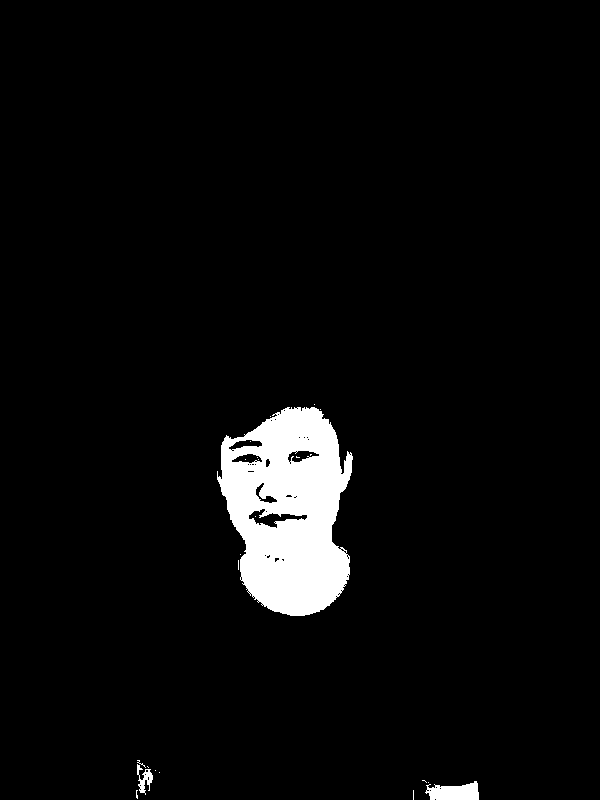

In [12]:
Image.fromarray(skin_map_arr)

In [13]:
def flood_fill(image_arr, row_start, col_start):
    global min_x, min_y, max_x, max_y
    if (row_start >= 0 and row_start < image_arr.shape[0] and col_start >= 0 and col_start < image_arr.shape[1]):
        if (image_arr[row_start][col_start] == 255):
            if (row_start < min_y):
                min_y = row_start
            if (row_start > max_y):
                max_y = row_start
            if (col_start < min_x):
                min_x = col_start
            if (col_start > max_x):
                max_x = col_start
                
            image_arr[row_start][col_start] = 0
            flood_fill(image_arr, row_start + 1, col_start) # bottom
            flood_fill(image_arr, row_start - 1, col_start) # top
            flood_fill(image_arr, row_start, col_start + 1) # right
            flood_fill(image_arr, row_start, col_start - 1) # left
            flood_fill(image_arr, row_start - 1, col_start - 1) # upper left
            flood_fill(image_arr, row_start - 1, col_start + 1) # upper right
            flood_fill(image_arr, row_start + 1, col_start - 1) # bottom left
            flood_fill(image_arr, row_start + 1, col_start + 1) # bottom right

In [14]:
candidate_face = []
for idx_row, row in enumerate(skin_map_arr):
    for idx_col, col in enumerate(row):
        if col == 255:
            max_x = -9999
            max_y = -9999
            min_x = 9999
            min_y = 9999
            flood_fill(skin_map_arr, idx_row, idx_col)
            candidate_face.append((min_x, max_x, min_y, max_y))

In [15]:
def filter_with_ratio(candidate_face):
    result = []
    for min_col, max_col, min_row, max_row in candidate_face:
        width = max_col - min_col
        height = max_row - min_row
        if width != 0:
            ratio = height / width

            result.append((min_col, max_col, min_row, max_row))
                
    return result

In [16]:
ratio_filter_result = filter_with_ratio(candidate_face)

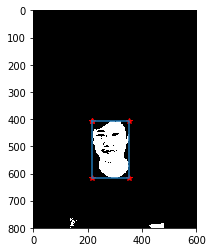

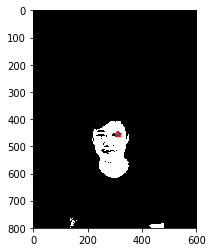

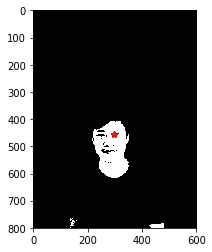

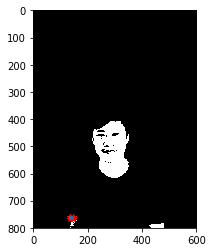

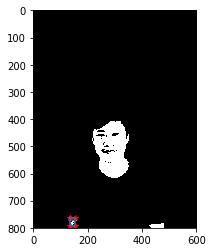

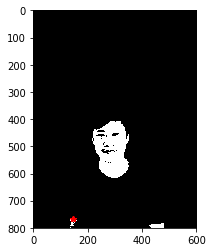

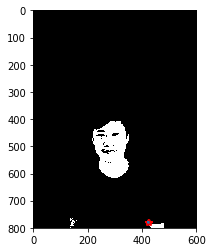

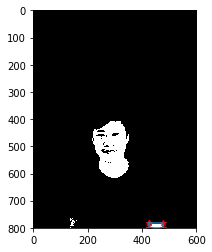

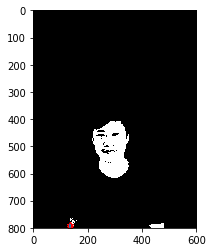

In [17]:
for min_col, max_col, min_row, max_row in ratio_filter_result:
    x = [min_col, max_col, max_col, min_col, min_col]
    y = [min_row, min_row, max_row, max_row, min_row]
    imshow(image_face)
    plot(x, y, 'r*')
    plot(x, y)
    show()

In [18]:
def use_sobel(img, width, height):
    newimg = Image.new("RGB", (width, height), "white")
    for x in range(1, width-1):  # ignore the edge pixels for simplicity (1 to width-1)
        for y in range(1, height-1): # ignore edge pixels for simplicity (1 to height-1)

            # initialise Gx to 0 and Gy to 0 for every pixel
            Gx = 0
            Gy = 0

            # top left pixel
            p = img.getpixel((x-1, y-1))
            r = p[0]
            g = p[1]
            b = p[2]

            # intensity ranges from 0 to 765 (255 * 3)
            intensity = r + g + b

            # accumulate the value into Gx, and Gy
            Gx += -intensity
            Gy += -intensity

            # remaining left column
            p = img.getpixel((x-1, y))
            r = p[0]
            g = p[1]
            b = p[2]

            Gx += -2 * (r + g + b)

            p = img.getpixel((x-1, y+1))
            r = p[0]
            g = p[1]
            b = p[2]

            Gx += -(r + g + b)
            Gy += (r + g + b)

            # middle pixels
            p = img.getpixel((x, y-1))
            r = p[0]
            g = p[1]
            b = p[2]

            Gy += -2 * (r + g + b)

            p = img.getpixel((x, y+1))
            r = p[0]
            g = p[1]
            b = p[2]

            Gy += 2 * (r + g + b)

            # right column
            p = img.getpixel((x+1, y-1))
            r = p[0]
            g = p[1]
            b = p[2]

            Gx += (r + g + b)
            Gy += -(r + g + b)

            p = img.getpixel((x+1, y))
            r = p[0]
            g = p[1]
            b = p[2]

            Gx += 2 * (r + g + b)

            p = img.getpixel((x+1, y+1))
            r = p[0]
            g = p[1]
            b = p[2]

            Gx += (r + g + b)
            Gy += (r + g + b)

            # calculate the length of the gradient (Pythagorean theorem)
            length = math.sqrt((Gx * Gx) + (Gy * Gy))

            # normalise the length of gradient to the range 0 to 255
            length = length / 4328 * 255

            length = int(length)

            # draw the length in the edge image
            #newpixel = img.putpixel((length,length,length))
            newimg.putpixel((x,y),(length,length,length))
    return newimg

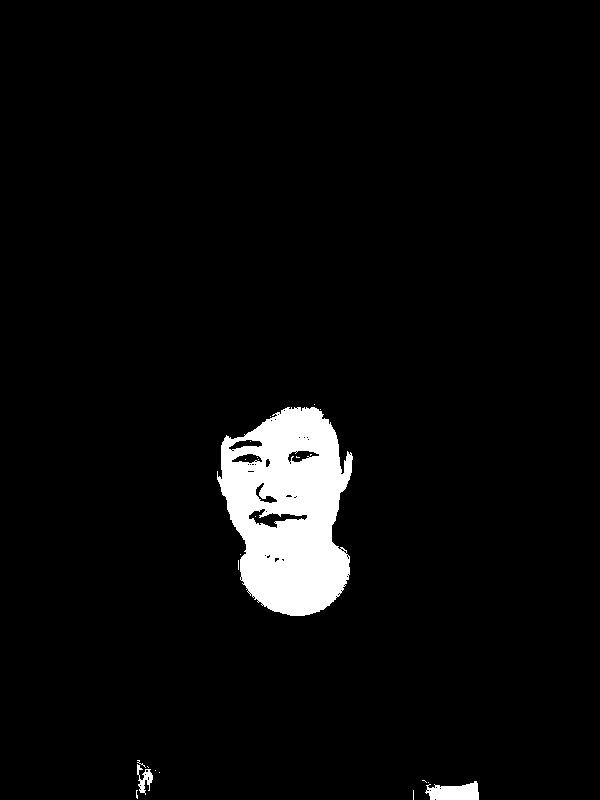

In [19]:
Image.fromarray(image_face)

# Sobel

In [20]:
sobel_image = use_sobel(Image.fromarray(image_sobel), image_sobel.shape[1], image_sobel.shape[0])

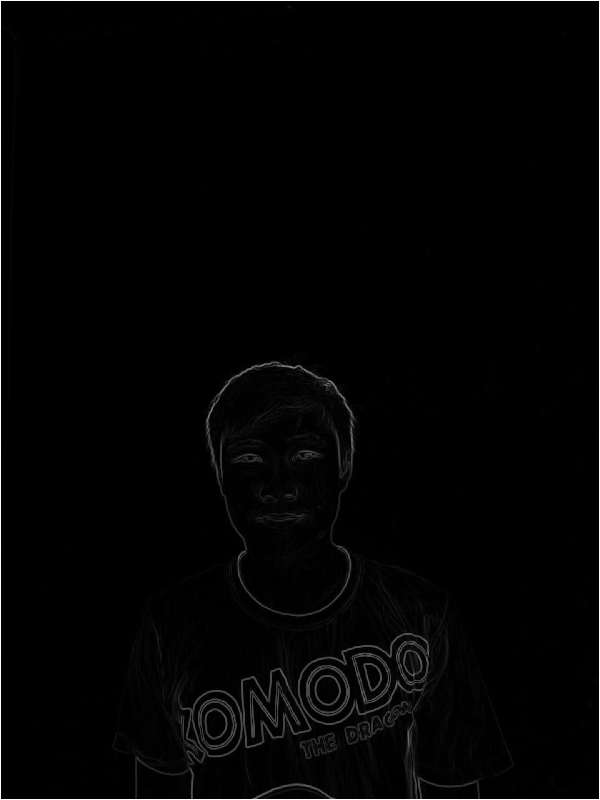

In [21]:
sobel_image

In [22]:
sobel_image_arr = array(sobel_image)

# Coba

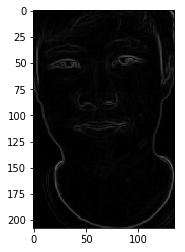

In [23]:
for min_col, max_col, min_row, max_row in ratio_filter_result:
    x = [min_col, max_col, max_col, min_col, min_col]
    y = [min_row, min_row, max_row, max_row, min_row]
    image_face_new = Image.fromarray(sobel_image_arr).crop((min_col, min_row, max_col, max_row)).convert('L')
    imshow(image_face_new)
    image_arr = array(image_face_new)
    show()
    break

In [24]:
image_arr.shape

(208, 135)

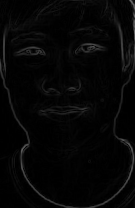

In [25]:
Image.fromarray(image_arr)

In [26]:
def image_dilation(image_arr):
    # the structuring element is a 5 pixel x 5 pixel square
    height = image_arr.shape[0]
    widht = image_arr.shape[1]
    new_image = image_arr.copy()
    for pixel_y in range(height):
        for pixel_x in range(widht):
            roi = image_arr[max(0, pixel_y - 2): min(height, pixel_y + 3),
                                    max(0, pixel_x - 2): min(widht, pixel_x + 3)]
            new_image[pixel_y][pixel_x] = np.amax(roi)
    return new_image

In [27]:
def image_erosion(image_arr):
    # the structuring element is a 5 pixel x 5 pixel square
    height = image_arr.shape[0]
    widht = image_arr.shape[1]
    new_image = image_arr.copy()
    for pixel_y in range(height):
        for pixel_x in range(widht):
            roi = image_arr[max(0, pixel_y - 2): min(height, pixel_y + 3),
                                    max(0, pixel_x - 2): min(widht, pixel_x + 3)]
            new_image[pixel_y][pixel_x] = np.amin(roi)
    return new_image

In [28]:
def image_closing(image_arr):
    dilated = image_dilation(image_arr)
    eroded = image_erosion(dilated)
    return eroded

In [29]:
def image_opening(image_arr):
    eroded = image_erosion(image_arr)
    dilated = image_dilation(eroded)
    return dilated

In [30]:
new_image_dilation = image_dilation(image_arr)

In [31]:
new_image_erosion = image_erosion(image_arr)

In [32]:
new_image_closing = image_closing(image_arr)

In [33]:
new_image_opening = image_opening(image_arr)

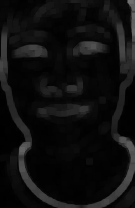

In [34]:
Image.fromarray(new_image_dilation)

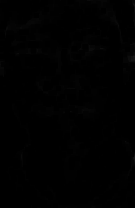

In [35]:
Image.fromarray(new_image_erosion)

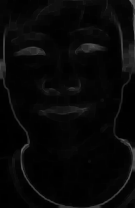

In [36]:
Image.fromarray(new_image_closing)

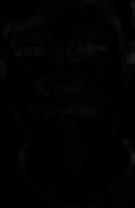

In [37]:
Image.fromarray(new_image_opening)

# Coba 2

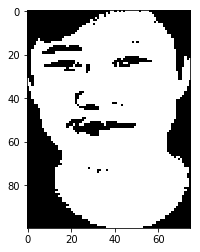

In [38]:
for min_col, max_col, min_row, max_row in ratio_filter_result:
    x = [min_col, max_col, max_col, min_col, min_col]
    y = [min_row, min_row, max_row, max_row, min_row]
    image_face_new = Image.fromarray(image_face).crop((min_col, min_row, max_col, max_row)).convert('L').resize((75, 100))
    imshow(image_face_new)
    image_arr = array(image_face_new)
    show()
    break

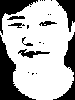

In [39]:
Image.fromarray(image_arr)

In [40]:
new_image_dilation = image_dilation(image_arr)

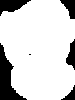

In [41]:
Image.fromarray(new_image_dilation)

In [42]:
new_image_erosion = image_erosion(image_arr)

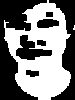

In [43]:
Image.fromarray(new_image_erosion)

In [44]:
new_image_opening = image_opening(image_arr)

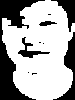

In [45]:
Image.fromarray(new_image_opening)

In [46]:
new_image_closing = image_closing(image_arr)

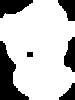

In [47]:
Image.fromarray(new_image_closing)

In [48]:
def get_valid_index(image_arr, row, column):
    if row < 0 or column < 0:
        return 0
    elif row >= image_arr.shape[0]:
        return image_arr.shape[0] - 1
    elif column >= image_arr.shape[1]:
        return image_arr.shape[1] - 1
    else:
        return image_arr[row][column]

In [49]:
def image_dilation_disk(image_arr):
    # the structuring element is a 3 pixel x 3 pixel disk
    height = image_arr.shape[0] - 1
    widht = image_arr.shape[1] - 1
    new_image = image_arr.copy()
    for pixel_y in range(height):
        for pixel_x in range(widht):
            roi1 = image_arr[min(height, pixel_y + 3)][pixel_x]
            roi2 = image_arr[min(height, pixel_y + 2)][max(0, pixel_x - 2): min(pixel_x + 3, widht)]
            roi3 = image_arr[min(height, pixel_y + 1)][max(0, pixel_x - 2): min(pixel_x + 3, widht)]
            roi4 = image_arr[pixel_y][max(0, pixel_x - 3): min(pixel_x + 4, widht)]
            roi5 = image_arr[max(0, pixel_y - 1)][max(0, pixel_x - 2): min(pixel_x + 3, widht)]
            roi6 = image_arr[max(0, pixel_y - 2)][max(0, pixel_x - 2): min(pixel_x + 3, widht)]
            roi7 = image_arr[max(0, pixel_y - 3)][pixel_x]
            amax1 = np.amax(roi1)
            amax2 = np.amax(roi2)
            amax3 = np.amax(roi3)
            amax4 = np.amax(roi4)
            amax5 = np.amax(roi5)
            amax6 = np.amax(roi6)
            amax7 = np.amax(roi7)
            roi = np.array([amax1, amax2, amax3, amax4, amax5, amax6, amax7])
            new_image[pixel_y][pixel_x] = np.amax(roi)
    return new_image

In [50]:
def image_erosion_disk(image_arr):
    # the structuring element is a 3 pixel x 3 pixel disk
    height = image_arr.shape[0]
    widht = image_arr.shape[1]
    new_image = image_arr.copy()
    for pixel_y in range(height):
        for pixel_x in range(widht):
            roi1 = image_arr[min(height - 1, pixel_y + 3)][pixel_x]
            roi2 = image_arr[min(height - 1, pixel_y + 2)][max(0, pixel_x - 2): min(pixel_x + 3, widht)]
            roi3 = image_arr[min(height - 1, pixel_y + 1)][max(0, pixel_x - 2): min(pixel_x + 3, widht)]
            roi4 = image_arr[pixel_y][max(0, pixel_x - 3): min(pixel_x + 4, widht)]
            roi5 = image_arr[max(0, pixel_y - 1)][max(0, pixel_x - 2): min(pixel_x + 3, widht)]
            roi6 = image_arr[max(0, pixel_y - 2)][max(0, pixel_x - 2): min(pixel_x + 3, widht)]
            roi7 = image_arr[max(0, pixel_y - 3)][pixel_x]
            amax1 = np.amin(roi1)
            amax2 = np.amin(roi2)
            amax3 = np.amin(roi3)
            amax4 = np.amin(roi4)
            amax5 = np.amin(roi5)
            amax6 = np.amin(roi6)
            amax7 = np.amin(roi7)
            roi = np.array([amax1, amax2, amax3, amax4, amax5, amax6, amax7])
            new_image[pixel_y][pixel_x] = np.amin(roi)
    return new_image

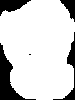

In [51]:
Image.fromarray(image_dilation_disk(image_arr))

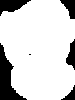

In [52]:
Image.fromarray(image_dilation(image_arr))

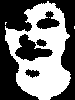

In [53]:
Image.fromarray(image_erosion_disk(image_arr))